<a href="https://colab.research.google.com/github/Shaileshps21/diffusion_model/blob/main/turbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alik033/TURBIT

Cloning into 'TURBIT'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 97 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 5.01 MiB | 12.17 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
%cd TURBIT

/content/TURBIT


In [3]:
!pip install timm
!pip install diffusers
!pip install accelerate


Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102 (from 1)
Receiving objects: 100% (102/102), 6.37 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (55/55), done.


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
100%|██████████| 2.70G/2.70G [01:02<00:00, 43.5MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your 

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/250 [00:00<?, ?it/s]

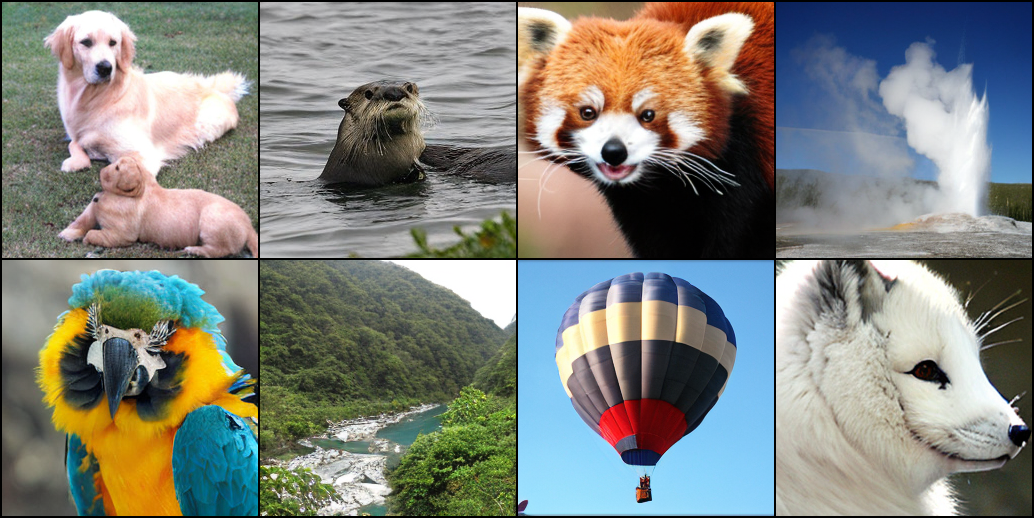

In [5]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [6]:
!python download.py

100% 2.70G/2.70G [00:13<00:00, 194MB/s]
Done.


In [8]:
!python train.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
usage: train.py [-h] --data-path DATA_PATH [--results-dir RESULTS_DIR]
     

In [7]:
!python sample.py

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py